In [1]:
import h5py
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
import caiman as cm

In [7]:
directory = '/media/david/hdd1/David_GCAMP/20210820'
filename = 'file_00008'

In [11]:
#Read tag file
dict_name = directory+'/tag/'+filename+'.json'
with open(dict_name, 'r') as f:
    tag = json.load(f)
display_tag = tag.copy()
display_tag.pop('metadata')
print(display_tag)

{'total_volume': 1, 'framesPerSlice': 3000, 'num_slice': 1, 'FrameRate': 30.0033, 'numFramesPerVolume': 3000, 'pixelsPerLine': 512, 'linesPerFrame': 512, 'scanZoomFactor': 5, 'stackZStepSize': 5, 'length': 3000}


In [3]:
#Read results
num_slice = 1
name = directory+'/preprocess/'+filename+'_'+str(num_slice)+'.hdf5'
cnm2 = h5py.File(name,'r')

In [4]:
#shape, indices, indptr, data are used to produce sparse matrix A
shape = cnm2['estimates']['A']['shape'][:]
indices = cnm2['estimates']['A']['indices'][:]
indptr = cnm2['estimates']['A']['indptr'][:]
data = cnm2['estimates']['A']['data'][:]
#Shape of the picture (pixel*pixel)
dims = cnm2['dims'][:]
#Spatial component (num of pixel^2,num of components)
A = sparse.csr_matrix((data, indices, indptr),shape=(shape[1],shape[0])).transpose()
#Temporal component (num of components, time steps)
C = cnm2['estimates']['C'][:]
#Background spatial component (num of pixel^2,num of components)
b = cnm2['estimates']['b'][:]
#Background temporal component (num of background components, time steps)
f = cnm2['estimates']['f'][:]
#A.dot(C) is spatial-temporal component of neurons, b.dot(f) is spatial-temporal component of background
denoised = (A.dot(C)+b.dot(f)).reshape((dims[0],dims[1])+(-1,),order='F').transpose([2, 0, 1])#denoised movie
denoised_only_neuron = (A.dot(C)).reshape((dims[0],dims[1])+(-1,),order='F').transpose([2, 0, 1])#denoised total neurons
#np.save(directory+'/denoise/''+'denoise_'+filename,denoised)

#Deconvolved neural activity (spikes)
S = cnm2['estimates']['S'][:]
#DF/F normalized temporal compoment
F_dff = cnm2['estimates']['F_dff'][:]
#Residual components
YrA = cnm2['estimates']['YrA'][:]



In [5]:
#%% Extract DF/F values---Without YrA(Residual components)
#I think f_dff is better than F_dff, but F_dff is closer to real data
f_dff = cm.source_extraction.cnmf.utilities.detrend_df_f(A, b, C, f,YrA=None,quantileMin=10,frames_window=400,flag_auto=False)
#quantile_min:quantile used to estimate the baseline (values in [0,100])
#frames_window:number of frames for computing running quantile
#flag_auto: bool, flag for determining quantile automatically

The number of components is 65


Text(0.5, 1.0, 'dF/F')

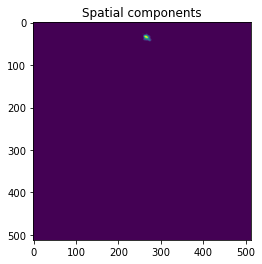

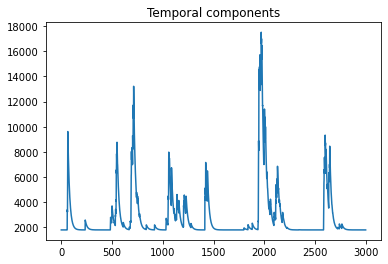

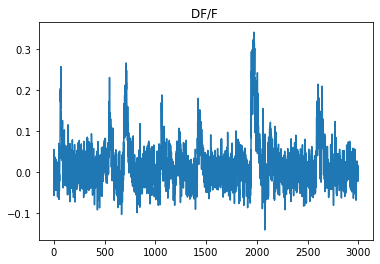

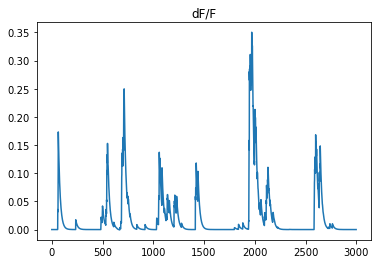

In [6]:
#Num of qunalified components
num_components = A.shape[1]
print('The number of components is '+str(num_components))
#spatial components
i = 60#i-th compoment, which means i-th neurons
plt.figure(); plt.imshow(np.reshape(A[:,i-1].toarray(), dims, order='F'))
plt.title('Spatial components')
#Temporal components
plt.figure(); plt.plot(C[i-1])
plt.title('Temporal components')
#Deconvolved neural activity (spikes)
#plt.figure();plt.plot(S[i-1,:])
#DF/F normalized temporal compoment
plt.figure();plt.plot(F_dff[i-1,:])
plt.title('DF/F ')
#DF/F normalized temporal compoment without Residual components (lower noises)
plt.figure();plt.plot(f_dff[i-1,:])
plt.title('dF/F')#Without noise